In [1]:
%run './model/multi_corpus.py'
%run './model/ergm_functions.py'
%run './constants.py'

sns.set(rc = {'figure.figsize':(15,8)})

import multiprocessing as mp
import polars as pl
from itertools import combinations
# mp.set_start_method('forkserver')
import math

import networkx as nx

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import scipy as sp

from itertools import product
from scipy.special import comb
from sklearn.preprocessing import MinMaxScaler

import os

from scipy.spatial.distance import cosine
from scipy.stats import norm

import pytensor.tensor as pt

from IPython.display import display

# RANDOM_SEED = 8927
# rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
corpora = citation_graphs()
Gs = {field_name: corpus['G'] for (field_name, corpus) in corpora.items()}
Dfs = {field_name: corpus['Df'] for (field_name, corpus) in corpora.items()}

Gender Studies DiGraph with 2224 nodes and 4332 edges
Geometry DiGraph with 2121 nodes and 2652 edges
Geophysics DiGraph with 38952 nodes and 162177 edges
Economics DiGraph with 7147 nodes and 55537 edges
Language & Linguistics DiGraph with 3128 nodes and 13572 edges
Probability & Statistics DiGraph with 5496 nodes and 19273 edges
Material Engineering DiGraph with 39045 nodes and 253189 edges
Artificial Intelligence DiGraph with 5475 nodes and 21705 edges
Sociology DiGraph with 4083 nodes and 25676 edges
International Business DiGraph with 5254 nodes and 36786 edges
Political Science DiGraph with 5305 nodes and 26335 edges
Genetics & Genomics DiGraph with 26776 nodes and 109991 edges
Immunology DiGraph with 27301 nodes and 195148 edges
Human Resources & Organizations DiGraph with 5848 nodes and 34965 edges
Ethnic & Cultural Studies DiGraph with 2105 nodes and 4041 edges
Neurology DiGraph with 32881 nodes and 282230 edges


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


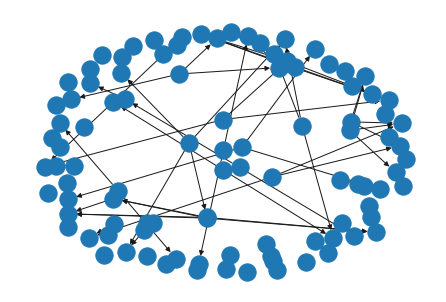

In [33]:
G = Gs['Gender Studies']

n = 100
c = nx.in_degree_centrality
# c = nx.betweenness_centrality

cent_dict = c(G)
cent_lst = sorted(cent_dict.items(), key=lambda tup: tup[1], reverse=True)
nodes = [doi for doi, _ in cent_lst[:n]]

G = G.subgraph(nodes)



nx.draw(G)


In [16]:
def date(G, df, t):

    # if two nodes are within t years of each other 1, otherwise 0
    
    nodes = np.array(G.nodes)
    delta_mat = np.zeros((nodes.size, nodes.size))

    for (u, v) in combinations(nodes, 2):

        year_u, = df.filter(pl.col('Doi').eq(pl.lit(u))).select(pl.col('Date').dt.year()).row(0)
        year_v, = df.filter(pl.col('Doi').eq(pl.lit(v))).select(pl.col('Date').dt.year()).row(0)

        if abs(year_u - year_v) <= t:
            delta = 1
        else:
            delta = 0

        idx_u = np.where(nodes == u)[0]
        idx_v = np.where(nodes == v)[0]

        delta_mat[idx_u, idx_v] = delta

    return delta_mat

In [ ]:
def delta_f(G, f, undirected=True):

    nodes = np.array(G.nodes)
    delta_mat = np.zeros((nodes.size, nodes.size))

    for (u, v) in combinations(nodes, 2):

        G_without = G.copy()
        G_with = G.copy()

        if not G_with.has_edge(u, v): G_with.add_edge(u, v)
        if G_without.has_edge(u, v): G_without.remove_edge(u, v)

        stat_delta = f(G_with) - f(G_without)

        idx_u = np.where(nodes == u)[0]
        idx_v = np.where(nodes == v)[0]

        delta_mat[idx_u, idx_v] = stat_delta

    return delta_mat

In [ ]:
def edges(G):
    return len(G.edges)

def triangles(G):
    return sum(nx.triangles(G).values()) / 3

In [18]:
delta_edges = lambda G: delta_f(G, edges)
delta_triangles = lambda G: delta_f(G, triangles)

In [19]:
tables = []
dist = {}

for (field_name, d) in corpora.items():

    print(field_name)

    G = d['G']
    df = d['Df']

    observed = nx.to_numpy_array(G, weight=None)

    βs_xs = {
        'Density': delta_edges(G),
        'Triangles': delta_triangles(G),
        # 'Stars': delta_star(G, 3),
        # 'Betweenness': delta_betweenness(G),
        # 'Closeness': delta_closeness(G),
        # 'Eigenvector': delta_eigenvector(G),
        # 'Centralization': delta_centralization(G),
        # 'Clustering': delta_clustering(G),
        # 'Transitivity': delta_transitivity(G),
        # 'Cliques': delta_cliques(G),
        # 'Components': delta_components(G),
        # 'Gini': delta_gini(G),
        # 'Louvain': delta_louvain(G),
        'Date': date(G, df, 5)
        # 'Geodesic': delta_geodesic(G),
    }

    dist[field_name] = βs_xs

    with pm.Model() as model:

        βs = []
        xs = []
        for β_name, x in βs_xs.items():
            β = pm.Normal(β_name, sigma=1, initval=None)
            βs.append(β)
            xs.append(x)

        μ = sum(β * x for β, x in zip(βs, xs))

        likelihood = pm.math.sigmoid(μ)

        pm.Bernoulli(name='logit', p=likelihood, observed=observed)

        trace = pm.sample(
            tune=1000,
            draws=2000,
            chains=4,
            # init = 'adapt_diag',
            cores=4,
            # step=pm.Metropolis(),
            step=pm.NUTS(),
            # random_seed=12345,
        )

        trace.to_netcdf(os.path.join(os.path.join(OUTPUT_PATH, f'citation_traces'), f'{field_name}.nc'))


Gender Studies


KeyboardInterrupt: 